# **Real and Fake Face detection**
In this replository is a small application that uses a CNN to predict real or fake face.

Data has been collected from kaggle. For training ~1450 images and with an additional ~300 images for validation.

In [29]:
!pip uninstall tensorflow -y
!pip install tensorflow==2.6.0

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline



Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.6.0-cp38-cp38-manylinux2010_x86_64.whl (458.4 MB)


# **Dataset**
First let's load in the data I've collected from the program. I will use kera's ImageDataGenerator to not only label the data from the directories but also to slightly augment the data with shifts, rotations, zooms, and mirroring. Mirroring will help to ensure that the data are not biased to a particular handedness.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/dataset/training',
                                               target_size=(150,150),
                                               class_mode='binary')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/dataset/test',
                                             target_size=(150,150),
                                             class_mode='binary')


Found 1437 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


Text(0.5, 0, 'Class')

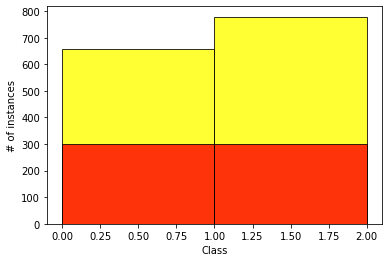

In [10]:
h1 = plt.hist(train_set.classes, bins=range(0,3), alpha=0.8, color='yellow', edgecolor='black')
h2 = plt.hist(test_set.classes,  bins=range(0,3), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('# of instances')
plt.xlabel('Class')


(32, 150, 150, 3) (32,)


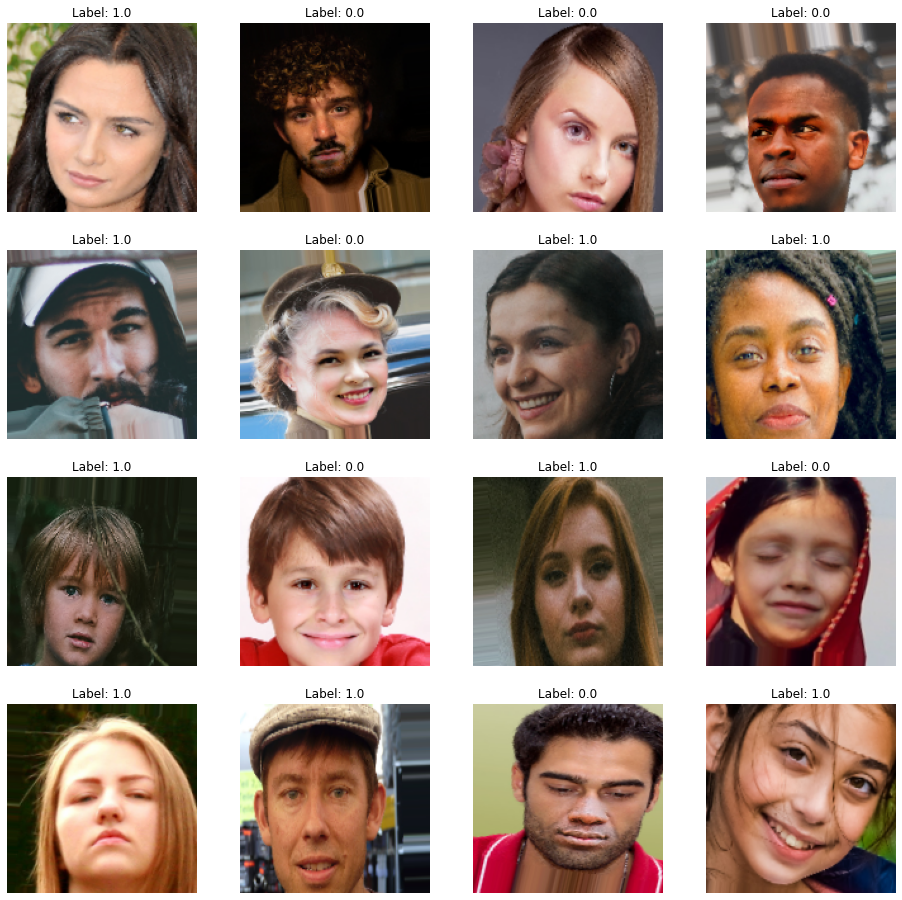

In [11]:
for X, y in train_set:
    print(X.shape, y.shape)
    plt.figure(figsize=(16,16))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Label: {}'.format(y[i]))
        img = np.uint8(255*X[i,:,:,:])
        plt.imshow(img, cmap='gray')
    break

# **Convolutional Neural Net**
The data looks resonable so now I will define a CNN model to train and use within our application.

In [12]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150,150,3)))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(activation="relu",
                units=256))

model.add(Dense(activation="sigmoid",
                units=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)            

**Compile the model**

In [13]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# **Training**
Finally we will train our model using some keras helper functions. We are not doing any hyper-parameter optimization so we will not define a separate testing and validation set. We can however evaluate our model further in real time within the application.

In [14]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model_checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode ='max'),
]

In [15]:
history = model.fit(
        train_set,
        steps_per_epoch=train_set.samples // nbatch,
        epochs=10,
        validation_data=test_set,
        validation_steps=test_set.samples // nbatch,
        callbacks = callbacks_list
    )

Epoch 1/10
11/11 [==============================] - 12s 814ms/step - loss: 0.7433 - accuracy: 0.5682 - val_loss: 0.6914 - val_accuracy: 0.5391
Epoch 2/10
11/11 [==============================] - 8s 727ms/step - loss: 0.6961 - accuracy: 0.4460 - val_loss: 0.6934 - val_accuracy: 0.4844
Epoch 3/10
11/11 [==============================] - 9s 890ms/step - loss: 0.6931 - accuracy: 0.5199 - val_loss: 0.6934 - val_accuracy: 0.4531
Epoch 4/10
11/11 [==============================] - 7s 651ms/step - loss: 0.6921 - accuracy: 0.5358 - val_loss: 0.6912 - val_accuracy: 0.5547
Epoch 5/10
11/11 [==============================] - 9s 868ms/step - loss: 0.6960 - accuracy: 0.5227 - val_loss: 0.6828 - val_accuracy: 0.6172
Epoch 6/10
11/11 [==============================] - 8s 725ms/step - loss: 0.6888 - accuracy: 0.5645 - val_loss: 0.7036 - val_accuracy: 0.4453
Epoch 7/10
11/11 [==============================] - 8s 700ms/step - loss: 0.6927 - accuracy: 0.5369 - val_loss: 0.7016 - val_accuracy: 0.4688
Epoch

In [16]:
train_set.class_indices

{'fake': 0, 'real': 1}

Text(0.5, 0, '# of epochs')

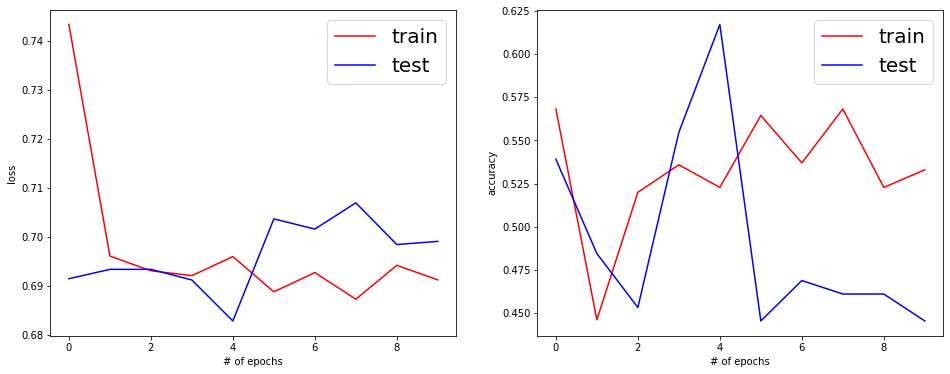

In [19]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('loss')
plt.xlabel('# of epochs')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['accuracy'],     'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('accuracy')
plt.xlabel('# of epochs')

# **Prediction**
Now the model is trained so I used some real images and edited that image so that we can analysis model is working correcly or not.

In [37]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (150,150))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

Enter Location of Image to predict: /content/drive/MyDrive/dataset/test/fake/mid_179_1111.jpg
Prediction:  Fake


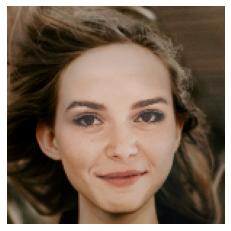

In [39]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

Enter Location of Image to predict: /content/drive/MyDrive/dataset/test/real/real_00783.jpg
Prediction:  Real


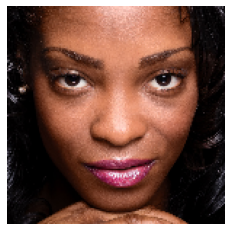

In [42]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

Enter Location of Image to predict: /content/drive/MyDrive/dataset/test/fake/mid_467_1111.jpg
Prediction:  Fake


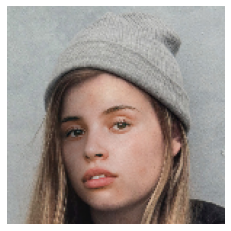

In [43]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

Enter Location of Image to predict: /content/drive/MyDrive/dataset/test/real/real_00902.jpg
Prediction:  Real


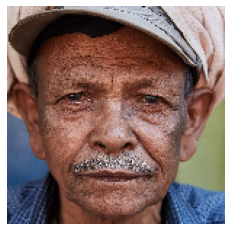

In [44]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

# **Result**
3 out of 4 images is predicted correctly althrough model is not trained well by incereasing epoc near about 40 will probably make this model perfectly trained but that will require 5-6hr for training.